# Skin Disease Detection Using PyTorch
Based on [Pneumonia detection using PYTORCH ](https://www.kaggle.com/code/dnik007/pneumonia-detection-using-pytorch)

Objective: Develop a computational image classification system to differentiate between malignant (neoplastic) and benign (non-neoplastic) dermatological conditions.

## Package Installation

In [1]:
!pip install torchsummary

Packages used in this notebook

In [2]:
# Data science tools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn as nn
from torchsummary import summary
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

# Image manipulations
from PIL import Image

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['font.size'] = 14

# Timing utility
from timeit import default_timer as timer

# Lists and counters
from collections import Counter

# General helpers
import os
from IPython.core.interactiveshell import InteractiveShell

# Surpress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


## Folder Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


⚠️**MODIFY THIS LINE TO MATCH YOUR FOLDER STRUCTURE**⚠️

TODO: Uncomment and modify this line to navigate to the correct folder:

Navigate to the 'datasets' folder or the location where you have the 'ddidiversedermatologyimages' folder stored

In [1]:
# cd /path/to/dataset/folder

In [6]:
# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

# Get the current directory
current_directory = os.getcwd()

# List all files in the current directory
files_in_directory = os.listdir(current_directory)

print("Files in the current directory:")
for file in files_in_directory:
    print(file)

Files in the current directory:
ddidiversedermatologyimages
vgg19-skin-4.pth
vgg19-skin-4.pt
vgg16-skin-4.pt
vgg16-skin-4.pth
resnet50-skin-4.pt
resnet50-skin-4.pth


In [7]:
# Current working directory
folder_name = 'ddidiversedermatologyimages'

# Metadata CSV file
metadata_path = 'ddidiversedermatologyimages/ddi_metadata.csv'

# Construct the relative path by joining the folder name with the current directory
folder_path = os.path.join(os.getcwd(), folder_name)

# OPTIONAL: Print all files and directories in the specified folder
contents = os.listdir(folder_path)
#print(contents)

In [8]:
# Create dataframe from metadata
df = pd.read_csv(metadata_path).drop("Unnamed: 0",axis="columns") # from csv of metadata

## Data Exploration

What does the dataframe look like?

In [9]:
df.head(3)

,DDI_ID,DDI_file,skin_tone,malignant,disease
0,1,000001.png,56,True,melanoma-in-situ
1,2,000002.png,56,True,melanoma-in-situ
2,3,000003.png,56,True,mycosis-fungoides


What datatypes are in the dataframe?

In [10]:
# Print metadata column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DDI_ID     656 non-null    int64 
 1   DDI_file   656 non-null    object
 2   skin_tone  656 non-null    int64 
 3   malignant  656 non-null    bool  
 4   disease    656 non-null    object
dtypes: bool(1), int64(2), object(2)
memory usage: 21.3+ KB


Let's get a breakdown of the skin tones in our dataset

In [11]:
# Count fo skin tones
count_skin_tones = df.skin_tone.value_counts()
count_skin_tones

34    241
12    208
56    207
Name: skin_tone, dtype: int64

To get a sense of what the skintone numbers mean, print an image from each of the skintone groups

Notes
- The function assumes the dataframe has a column named 'skin_tone' to filter by and a column named 'DDI_file' containing the image file names.
- The image is displayed using matplotlib's `imshow` function, with the axis turned off for a cleaner presentation.
- If no entries are found for the specified skin tone, or if the image file does not exist in the specified folder, the function prints an appropriate message.

In [12]:
def display_image_by_skin_tone(df, skin_tone, folder_path):
    """
    Display the first image corresponding to specified skin tone from dataframe.

    This function filters a dataframe for entries matching a specified skin tone, then attempts to display the first image corresponding to that skin tone. It assumes the dataframe contains a column with file names or identifiers for the images.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing image data, including skin tone and file identifiers.
    skin_tone : str or int
        The skin tone category to filter the dataframe by.
    folder_path : str
        The path to the folder containing the image files.

    Returns
    -------
    None
        The function does not return any value;
        Displays the image using matplotlib if found,
        or prints a message if no entries are found.
    """

    # Get a dataframe of just the specified skin tone
    filtered_df = df[df['skin_tone'] == skin_tone].reset_index(drop=True)

    if len(filtered_df) == 0:
        print(f"No entries found for skin tone {skin_tone}.")
        return

    # Get the value in the 'DDI_file' column of the first row
    file_value = filtered_df.loc[0, 'DDI_file']

    # Convert the value to a string
    image_filename = str(file_value)

    # Check if the image file exists in the specified folder
    if os.path.exists(os.path.join(folder_path, image_filename)):
        print(f"skin tone: {skin_tone}")
        img = mpimg.imread(os.path.join(folder_path, image_filename))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print(f"Image {image_filename} not found in the specified folder.")


skin tone: 56


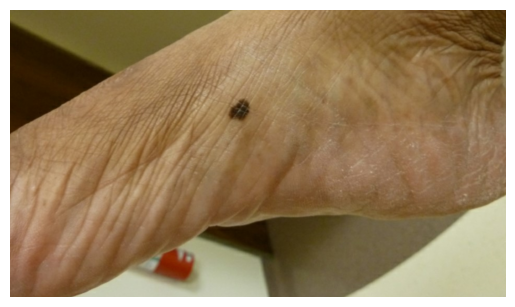

skin tone: 12


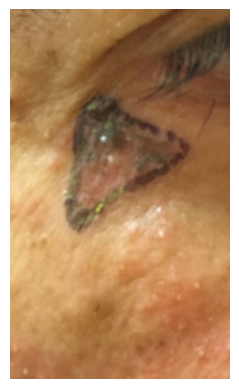

skin tone: 34


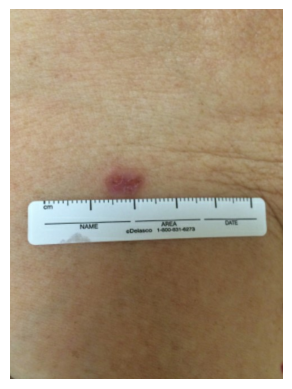

In [13]:
distinct_skin_tones = df['skin_tone'].unique().tolist()
for skin_tone in distinct_skin_tones:
  display_image_by_skin_tone(df, skin_tone, folder_path)

Not a lot of variety in skin tones...

### Plots and Charts

Replace skintones with abitrary letter to make sure training later does not attribute important characteristics to numerical differences

In [14]:
# Define the mapping of values to be replaced
replacement_mapping = {12: 'a', 34: 'b', 56: 'c'}

# Update the 'skin_tone' column using the mapping
df['skin_tone'] = df['skin_tone'].replace(replacement_mapping)

# Check the updated DataFrame
print(df.head())

   DDI_ID    DDI_file skin_tone  malignant                          disease
0       1  000001.png         c       True                 melanoma-in-situ
1       2  000002.png         c       True                 melanoma-in-situ
2       3  000003.png         c       True                mycosis-fungoides
3       4  000004.png         c       True  squamous-cell-carcinoma-in-situ
4       5  000005.png         a       True             basal-cell-carcinoma


Text(0.5, 0, 'count skin tones')

Text(0, 0.5, 'skin tone')

Text(0.5, 1.0, 'Skin Tones in Data Set')

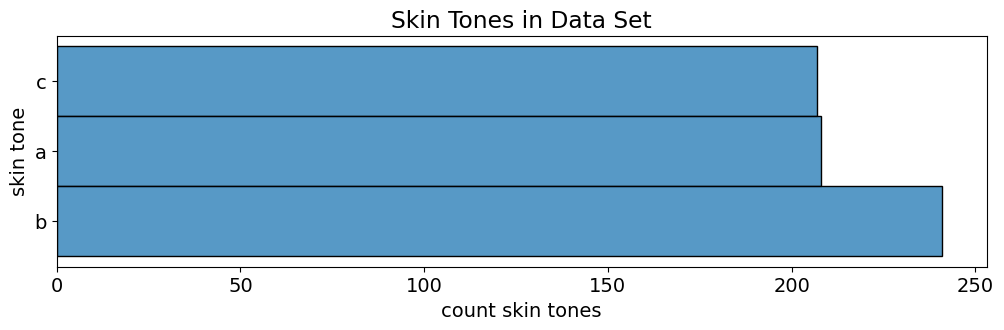

In [15]:
# Visualize Skin tone count
f, ax = plt.subplots(figsize=(12, 3))
ax = sns.histplot(data=df, y='skin_tone')
ax.set_xlabel('count skin tones')
ax.set_ylabel('skin tone')
ax.set_title('Skin Tones in Data Set')
plt.show()

Text(0.5, 1.0, 'Percentage of Malignant/Benign Skin Conditions')

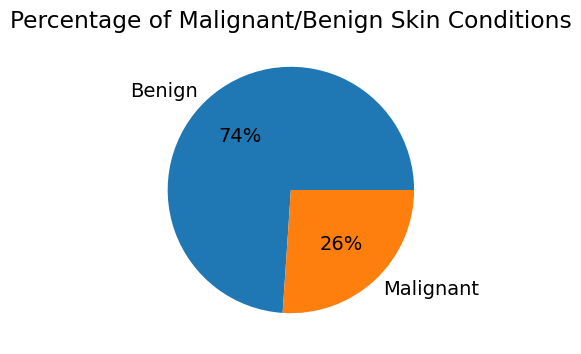

In [16]:
# Visualize malignant vs benign in dataset
f, ax = plt.subplots(figsize=(4, 4))
data = df.malignant.value_counts()
keys = ['Benign','Malignant']
ax = plt.pie(data, labels=keys, autopct='%.0f%%')
plt.title('Percentage of Malignant/Benign Skin Conditions')
plt.show()

Visualize benign vs malignant by skin tone

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='Skin Tone', ylabel='Count'>

Text(0.5, 0, 'Skin Tone')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Number of Malignant vs Benign Entries by Skin Tone')

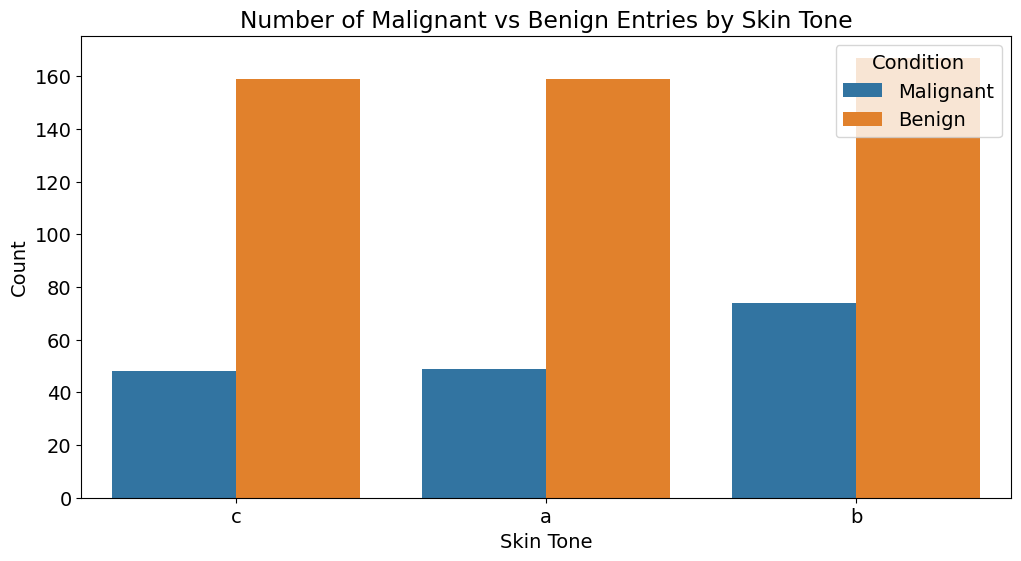

In [17]:
# Create a DataFrame for malignant and benign entries
malignant_df = df[df['malignant'] == True]
benign_df = df[df['malignant'] == False]

# Count the occurrences of each skin tone for malignant and benign entries
malignant_counts = malignant_df['skin_tone'].value_counts()
benign_counts = benign_df['skin_tone'].value_counts()

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Skin Tone': df['skin_tone'].unique(),
    'Malignant': [malignant_counts.get(tone, 0) for tone in df['skin_tone'].unique()],
    'Benign': [benign_counts.get(tone, 0) for tone in df['skin_tone'].unique()]
})

# Melt the DataFrame for easy plotting
melted_df = pd.melt(plot_df, id_vars='Skin Tone', var_name='Condition', value_name='Count')

# Plot the grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Skin Tone', y='Count', hue='Condition', data=melted_df)
plt.xlabel('Skin Tone')
plt.ylabel('Count')
plt.title('Number of Malignant vs Benign Entries by Skin Tone')
plt.show()

## Load Images

Notes
- The function uses PIL (Python Imaging Library) for loading the image.
- Converting the image to 'RGB' ensures compatibility with models that expect 3-channel input.
- Some images might have 4 channels (including an alpha/transparency channel); this function converts them to 3-channel RGB.

In [18]:
# Define the function to load and preprocess images
def load_and_preprocess_image(file_path):
    """
    Load and preprocess an image from a given file path.

    This function loads an image from the specified file path,
    converts it to a 3-channel RGB format (if not already in this format),
    and then converts it to a NumPy array.

    Parameters
    ----------
    file_path (str): The file path of the image to be loaded and preprocessed.

    Returns
    -------
    image (ndarray): The preprocessed image as a NumPy (3-channel RGB format).
    """
    image = Image.open(file_path)
    image = image.convert('RGB')
    image = np.array(image)
    return image

In [19]:
# Load and preprocess images for the entire dataset
image_data = []
labels = []
count = 0

for index, row in df.iterrows():
    count += 1
    image_path = 'ddidiversedermatologyimages/' + row['DDI_file']
    label = row['malignant']
    image = load_and_preprocess_image(image_path)
    image_data.append(image)
    labels.append(label)

# Convert image_data and labels to NumPy arrays
image_data = np.array(image_data,dtype=object)
labels = np.array(labels,dtype=int)

In [20]:
# Sanity check
print(type(labels))
print(labels[:50])

<class 'numpy.ndarray'>
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 0 0 0 1]


### Split into Train, Validation, and Test

In [21]:
# Split the data into training, validation, and testing sets
X_train, X_intermediate, y_train, y_intermediate = train_test_split(image_data, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_intermediate, y_intermediate, test_size=0.5, random_state=42)

In [22]:
# sanity check
print(f"Total values in dataset: {len(X_train) + len(X_val) + len(X_test)}")
print(f"Training set has {len(X_train)} values and {len(y_train)} labels")
print(f"Validation set has {len(X_val)} values and {len(y_val)} labels")
print(f"Test set has {len(X_test)} values and {len(y_test)} labels")

Total values in dataset: 656
Training set has 524 values and 524 labels
Validation set has 66 values and 66 labels
Test set has 66 values and 66 labels


In [23]:
X_train[0].shape
y_train[0]

(386, 391, 3)

0

### Augment Training Data
In this section, we generate more images with corresponding labesl and add to training images and labels.

In [24]:
df.head(3)

,DDI_ID,DDI_file,skin_tone,malignant,disease
0,1,000001.png,c,True,melanoma-in-situ
1,2,000002.png,c,True,melanoma-in-situ
2,3,000003.png,c,True,mycosis-fungoides


#### Create Generator

In [25]:
# Create an ImageDataGenerator with desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

Test generator on one image

<Figure size 1000x1000 with 0 Axes>

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

<Axes: >

(-0.5, 947.5, 548.5, -0.5)

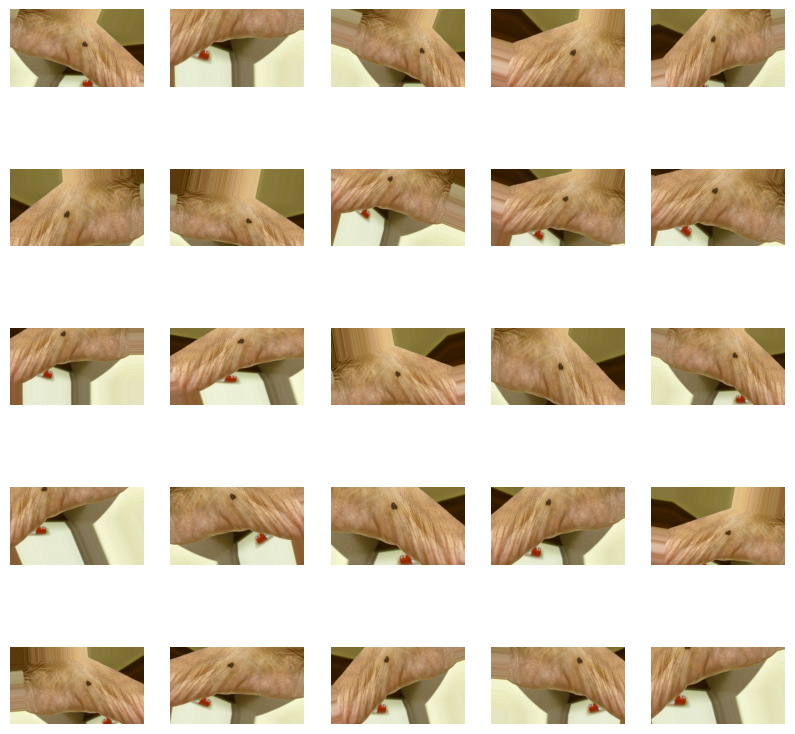

In [26]:
# Load and preprocess a sample image
image_path = 'ddidiversedermatologyimages/000001.png'
x = load_and_preprocess_image(image_path)
x = x.reshape((1,) + x.shape)

# Initialize a counter
i = 0

# Create a figure for plotting
plt.figure(figsize=(10, 10))

# Loop to generate and show transformed images
for batch in datagen.flow(x, batch_size=1):
    i += 1

    # Display the image
    plt.subplot(5, 5, i)
    plt.imshow(array_to_img(batch[0]))
    plt.axis('off')

    if i >= 25:
        break

# Show the images
plt.show()

#### Generate Transformed Images

Notes
- The function uses a global `datagen` object, which should be an instance of `ImageDataGenerator` from Keras, pre-configured with desired transformations.
- The function is designed to handle memory limitations by limiting the number of transformations.
- Each transformed image is converted back to 'uint8' type, which is a common format for images.

⚠️ WARNING ⚠️ Careful with the number of transformations; performing 25 transformations on each image in the dataset will cause the notebook to crash

In [27]:
# Function to apply transformations to an image and return a dataframe row
def generate_transformed_images(image, label, num_transformations=2): # not enough RAM for 25 tranformations
    """
    Generate a specified number of transformed images from a single input image.

    This function takes an image and its label, applies data augmentation transformations to the image, and returns a specified number of transformed images along with their corresponding labels.

    Parameters
    ----------
    image : ndarray
        The input image to be transformed. It should be a NumPy array.
    label : int
        The label corresponding to the input image.
    num_transformations : int, optional
        The number of transformed images to generate from the input image. Default is 2.

    Returns
    -------
    tuple of lists
        A tuple containing two lists:
        - The first list contains the transformed images.
        - The second list contains the labels for each transformed image, which are copies of the input image's label.
    """
    x = image.reshape((1,) + image.shape)
    transformed_images = []
    labels = []

    for batch in datagen.flow(x, batch_size=1):
        transformed_images.append((batch[0]).astype('uint8'))
        labels.append(label.astype('uint8'))
        if len(transformed_images) >= num_transformations:
            break
    return transformed_images, labels

In [28]:
# randomly generate 10 indexes from X_train to augment
idx_to_transform = np.random.choice(len(X_train), 100, replace=False)

transformed_X = []
transformed_y = []

# get img and label from X_train and y_train
for i in idx_to_transform:
  img = X_train[i]
  label = y_train[i]
  new_image, new_label = generate_transformed_images(img, label)
  transformed_X += new_image
  transformed_y += new_label

# add transformed_X to original training images X_trian
transformed_X = np.array(transformed_X, dtype=object)
X_train_aug = np.concatenate((X_train, transformed_X), axis=0)

# add transformed_y to original training labels y_train
transformed_y = np.array(transformed_y, dtype=object)
y_train_aug = np.concatenate((y_train, transformed_y), axis=0)

In [29]:
print("Data size before Augmentation: ", len(X_train))
print("Data size after Augmentation: ", len(X_train_aug))

Data size before Augmentation:  524
Data size after Augmentation:  724


In [30]:
# check the training labels
y_train_aug[:50]

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0], dtype=object)

### Load into Dataloader

In [31]:
# Define a custom dataset class by inheriting from torch.utils.data.Dataset
class CustomDataset(Dataset):
    """
    A custom dataset class for handling image data and labels for training machine learning models.

    This class is a subclass of PyTorch's Dataset and is used to create a dataset by providing data and corresponding labels. It supports optional transformations for data augmentation or preprocessing.

    Attributes
    ----------
    data : list or ndarray
        The dataset, which can be a list of image file paths or an array of images.
    labels : list or ndarray
        The corresponding labels for each data point in the dataset.
    transform : torchvision.transforms (optional)
        A torchvision transform or a composition of transforms to be applied to each data item.
    class_to_idx : dict
        A dictionary mapping each unique class label to an index.
    idx_to_class : dict
        A dictionary mapping each index back to its corresponding class label.

    Methods
    -------
    __init__(self, data, labels, transform=None):
        Initializes the dataset with data, labels, and an optional transform.

    __len__(self):
        Returns the size of the dataset.

    __getitem__(self, index):
        Retrieves an item from the dataset at the specified index. If the data is a file path, it loads the image, applies the transform (if any), and returns the image and its corresponding label.

    Parameters
    ----------
    data : list or ndarray
        The dataset, either as a list of file paths or an array of images.
    labels : list or ndarray
        The corresponding labels for the dataset.
    transform : torchvision.transforms, optional
        The transform(s) to be applied to each item in the dataset.

    Returns
    -------
    tuple
        A tuple containing the transformed sample and its corresponding label.
    """
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

        # Create a mapping from unique class labels to indices
        self.class_to_idx = {class_label: idx for idx, class_label in enumerate(set(labels))}

        # new
        self.idx_to_class = {idx: int(class_label) for class_label, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        # If the sample is a file path, load it as a PIL Image
        if isinstance(sample, str):
          sample = Image.open(sample).convert('RGB')
        if self.transform:
            sample = self.transform(sample)
        return sample, label


In [32]:
# Define data transforms for image preprocessing
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.ToTensor(), # Convert images to PyTorch tensors
        transforms.Resize((128,128)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.ToTensor(), # Convert images to PyTorch tensors
        transforms.Resize((128,128)), # (256,256)
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((128,128)), # (256,256)
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [33]:
# Set batch_size
batch_size=8

train_dataset = CustomDataset(X_train_aug, y_train_aug, transform=image_transforms['train'])
val_dataset = CustomDataset(X_val, y_val, transform=image_transforms['val'])
test_dataset = CustomDataset(X_test, y_test, transform=image_transforms['test'])

print(len(train_dataset))
print(len(val_dataset))
print(len(val_dataset))

724
66
66


In [34]:
# Dataloader iterators
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True),
    'test': DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
}

In [35]:
trainiter = iter(dataloaders['train'])
img, labels = next(trainiter) # issue with current augmentation set up: need to do totensor first
img.shape, labels.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([8, 3, 128, 128]), torch.Size([8]))

(0.0, 1.0, 0.0, 1.0)

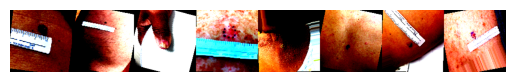

In [36]:
# Visualize one batch of images
row_of_images = torch.cat([img[i] for i in range(batch_size)], dim=2).permute(1,2,0)
plt.axis("off")
plt.imshow(row_of_images)
plt.show()

In [37]:
n_classes = len(torch.unique(labels))
n_classes

2

## Check Availability of GPU

In [38]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [39]:
print(train_on_gpu)

True


Now we will build models for the classification problem: VAE and pretrained models (vgg16, vgg19, resnet50)

## Pre-Trained Models

Since we have a limited dataset, we decided to try using pretrained models. In this section we will use 3 different pre-trained CNN-based models for classifier: vgg16, vgg19, and resnet50.

In [40]:
# create method to set model
def set_base_model(model_name):
  if model_name == 'vgg16':
    print("Setting model to vgg16")
    model = models.vgg16(pretrained=True)
    return model
  elif model_name == 'vgg19':
    print("Setting model to vgg19")
    model = models.vgg19(pretrained=True)
    return model
  elif model_name == 'resnet50':
    print("Setting model to resnet50")
    model = models.resnet50(pretrained=True)
    return model
  else:
    print("Invalid model name. No model returned.")

### Freezing and Modifying
#### Why modify bottom layers?

* Saw a similar approach taken in a Pneumonia detection study
  * They also had a relatively small dataset
  * Their strategy:
    * Freeze the early layers, and replace the classification module with custom classification approach
      * Pros:
        * Helps mitigate overfitting
        * Capture low level features (from training on ImageNet)
      * Con: Trains on a wide variety of data (not necessarily all relevant for our task)


In [41]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """
    print(f"looking for model named {model_name}")

    if model_name == 'vgg16':
        print("found vgg16")
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    if model_name == 'vgg19':
        model = models.vgg19(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    if train_on_gpu:
      model = model.to('cuda')

    if multi_gpu:
      model = nn.DataParallel(model)

    return model

### Model Setup
Re-run this line if failed attempt to run epochs below

In [59]:
# Basic mode
#model_name = 'vgg16'
#model_name = 'vgg19'
model_name = 'resnet50'
model = get_pretrained_model(model_name)
print(model)

looking for model named resnet50
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256

## Save and Checkpoint

In [60]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,033,090 total parameters.
525,058 training parameters.


In [61]:
# set model paths
def set_save_and_checkpoint_path(model_name):
  save_file_name =''
  checkpoint_path = ''
  if model_name == 'vgg19':
    print(f"Setting save and checkpoint path for {model_name}")
    save_file_name = 'vgg19-skin-4.pt'
    checkpoint_path = 'vgg19-skin-4.pth'
  elif model_name == 'vgg16':
    print(f"Setting save and checkpoint path for {model_name}")
    save_file_name = 'vgg16-skin-4.pt'
    checkpoint_path = 'vgg16-skin-4.pth'
  elif model_name == 'resnet50':
    print(f"Setting save and checkpoint path for {model_name}")
    save_file_name = 'resnet50-skin-4.pt'
    checkpoint_path = 'resnet50-skin-4.pth'
  return save_file_name, checkpoint_path

save_file_name, checkpoint_path = set_save_and_checkpoint_path(model_name)

Setting save and checkpoint path for resnet50


Print model summary

In [62]:
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           9,408
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]           4,096
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
           Conv2d-11           [8, 256, 56, 56]          16,384
      BatchNorm2d-12           [8, 256, 56, 56]             512
           Conv2d-13           [8, 256, 56, 56]          16,384
      BatchNorm2d-14           [8, 256,

In [63]:
model.class_to_idx = train_dataset.class_to_idx
model.idx_to_class = {
    idx: int(class_)
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 0), (1, 1)]

In [64]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])


## Training

### Why Pretrained models?
Skip the training process
PyTorch has many pretrained models we can use
All of these models have been trained on Imagenet which consists of millions of images across 1000 categories
* #### Why VGG16/19 and ResNet?
  * ##### **VGG16/19**
    * Pros:
      * Simple and uniform architecture
      * Often used for image classification tasks
    * Con:
      * Large number of parameters, and training them from scratch on a small dataset may lead to overfitting

  * ##### **ResNet50**
    * Pro:
      * With its skip connections, it allows for easier training of very deep networks
      * Performs well on small datasets


In [65]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """
    Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            '''for i in range(batch_size):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1'''

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

⚠️WARNING⚠️ Occasionally, the block below will error for one of the following reasons:
* Model has already been run
* GPU error in colab

If you receive an error stating
```
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-57-e7f1012da164> in <cell line: 1>()
----> 1 model, history = train(
      2     model,
      3     criterion,
      4     optimizer,
      5     dataloaders['train'],

2 frames
/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py in backward(tensors, grad_tensors, retain_graph, create_graph, grad_variables, inputs)
    249     # some Python versions print out the first line of a multi-line function
    250     # calls in the traceback and some print out the last line
--> 251     Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    252         tensors,
    253         grad_tensors_,

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
```
You can continue with the rest of the code below this block without restarting the notebook.

If you receive an error stating.
```
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-70-e7f1012da164> in <cell line: 1>()
----> 1 model, history = train(
      2     model,
      3     criterion,
      4     optimizer,
      5     dataloaders['train'],

<ipython-input-68-c8e50b5fe2af> in train(model, criterion, optimizer, train_loader, valid_loader, save_file_name, max_epochs_stop, n_epochs, print_every)
     63             # Tensors to gpu
     64             if train_on_gpu:
---> 65                 data, target = data.cuda(), target.cuda()
     66
     67             # Clear gradients
```
Please re-run the model setup block above.




In [66]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: 0.5534 	Validation Loss: 0.5878
		Training Accuracy: 75.00%	 Validation Accuracy: 78.79%

Epoch: 3 	Training Loss: 0.5132 	Validation Loss: 0.6428
		Training Accuracy: 77.49%	 Validation Accuracy: 68.18%

Epoch: 5 	Training Loss: 0.5095 	Validation Loss: 0.6258
		Training Accuracy: 77.35%	 Validation Accuracy: 77.27%

Early Stopping! Total epochs: 6. Best epoch: 1 with loss: 0.59 and acc: 69.70%
68.76 total seconds elapsed. 9.82 seconds per epoch.


### Plot Training and Validation Results

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

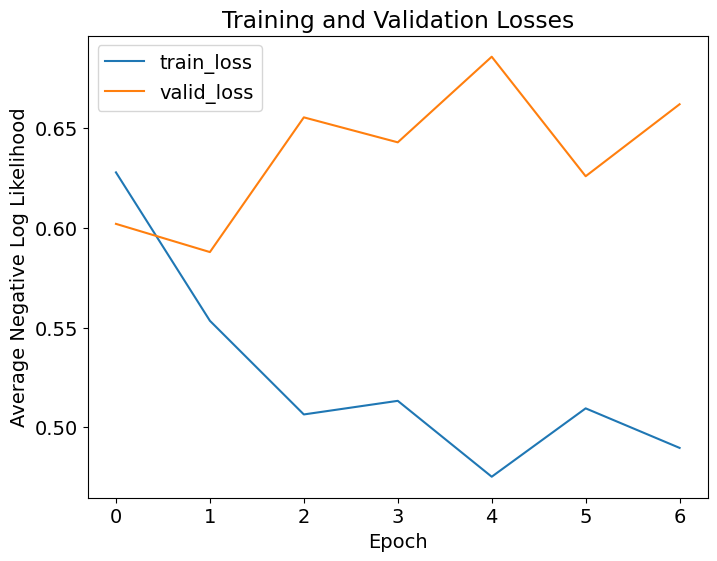

In [67]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

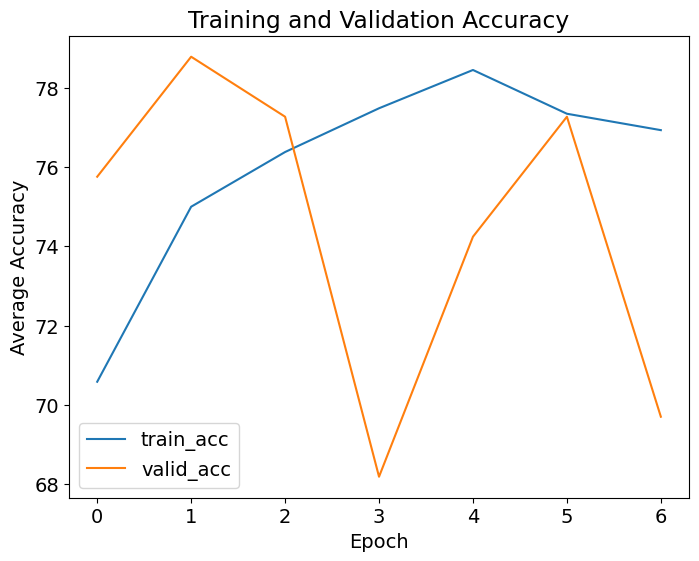

In [68]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

Model thinks it's learning but may just be memorizing; valization guesses aren't so good

### Save Checkpoint

In [69]:
def save_checkpoint(model, optimizer, path):
    """
    Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        optimizer (PyTorch optimizer): optimizer to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` and `optimizer` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg19', 'vgg16', 'resnet50']), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': getattr(model, 'class_to_idx', None),
        'idx_to_class': getattr(model, 'idx_to_class', None),
        'epochs': getattr(model, 'epochs', None),
    }

    # Extract the final classifier and the state dictionary
    if model_name in ['vgg19', 'vgg16']:
        classifier_key = 'classifier' if model_name == 'vgg19' else 'classifier'
        if getattr(model, 'module', None):
            checkpoint[classifier_key] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint[classifier_key] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if getattr(model, 'module', None):
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer_state_dict'] = optimizer.state_dict()

    print(checkpoint.keys())

    # Save the data to the path
    torch.save(checkpoint, path)

# Usage
save_checkpoint(model, optimizer, path=checkpoint_path)


dict_keys(['class_to_idx', 'idx_to_class', 'epochs', 'fc', 'state_dict', 'optimizer_state_dict'])


In [70]:
def load_checkpoint(path):
    """
    Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        model, optimizer: Loaded model and optimizer

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg19', 'vgg16', 'resnet50']), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg19':
        model = models.vgg19(pretrained=True)
        model.classifier = checkpoint['classifier']

    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    # Make sure to set parameters as not trainable
    for param in model.parameters():
        param.requires_grad = False

    # Recreate the optimizer
    optimizer = optim.Adam(model.parameters())  # Use the same optimizer and parameters as used during training
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Model basics
    if 'class_to_idx' in checkpoint:
        model.class_to_idx = checkpoint['class_to_idx']
    if 'idx_to_class' in checkpoint:
        model.idx_to_class = checkpoint['idx_to_class']
    if 'epochs' in checkpoint:
        model.epochs = checkpoint['epochs']

    # Move to gpu if available
    if torch.cuda.is_available():
        model = model.to('cuda')

    return model, optimizer


In [71]:
# Get model and optimizer
model, optimizer = load_checkpoint(path=checkpoint_path)

# Print model summary
if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           9,408
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]           4,096
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
           Conv2d-11           [8, 256, 56, 56]          16,384
      BatchNorm2d-12           [8, 256, 56, 56]             512
           Conv2d-13           [8, 256, 56, 56]          16,384
      BatchNorm2d-14           [8, 256,

In [72]:
print(len(dataloaders['test']))  # Print the length of the test DataLoader
for data, target in dataloaders['test']:
    print(data.shape, target.shape)  # Print the shape of each batch
    # Break after inspecting the first batch

1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([66, 3, 128, 128]) torch.Size([66])


In [73]:
def calculate_percentage_correct(values):
    """
    Helper that calcuates percent of correct predictions

    Params
    --------
        values (ndarray): array of prediction results (True = correct, False = incorrect)

    Returns
    --------
        percentage_true (float): percent of correct predictions

    """
    if not values.size:
        return 0.0  # Return 0% for an empty array

    count_false = np.count_nonzero(~values)
    print(f"\nnumber of incorrect predictions: {count_false}")

    count_true = np.count_nonzero(values)
    print(f"number of correct predictions: {count_true}")

    total_values = values.size
    percentage_true = (count_true / total_values) * 100

    return percentage_true

## Prediction

Test model and print accuracy

In [74]:
test_loader=dataloaders['test']
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = [0,1]
model.eval()

# initialize iteration counter
i=1

# iterate over test data
for data, target in test_loader:
    i=i+1

    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    # calculate the batch loss
    loss = criterion(output, target)

    # update test loss
    test_loss += loss.item()*data.size(0)

    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)

    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    # get percent of correct predictions
    percentage_correct = calculate_percentage_correct(correct)
    print(f"Percentage of True values: {percentage_correct:.2f}%")

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


number of incorrect predictions: 19
number of correct predictions: 47
Percentage of True values: 71.21%
Test Loss: 0.595416



## Summary

#### **What Didn't Work**
Though the freeze and modification of smaller layers seemed to work for exploreres of the pneumonia dataset, we did not see the same results. While our performance on the training set improved, performance on the validation set got worse. Again, we think this is due to overfitting.

#### **Pausible Causes for Overfitting**
* Smaller data set (compared to pneumonia study)
* More variety across photos in dataset

#### **Possible Paths Forward**
##### **Crop Region of Interest**
In the future we might try to target the area in question, center it, etc. to produce more uniform photos.

##### **Try Different Modifications to Bottom Layers**
We’d like to play around with different bottom layer classification approaches to see if we can get better performance for skin disease classification.